<a href="https://colab.research.google.com/github/Mahwish-source/Mahwish-source/blob/main/Credit_Risk_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Attempting to download dataset: madhansing/bank-loan2


100%|██████████| 13.6k/13.6k [00:00<00:00, 7.15MB/s]

Extracting files...
   -> Download successful. Files saved to: /root/.cache/kagglehub/datasets/madhansing/bank-loan2/versions/1
   -> Found data file: /root/.cache/kagglehub/datasets/madhansing/bank-loan2/versions/1/madfhantr.csv
   -> Data loaded into Pandas DataFrame successfully.

Loaded DataFrame Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

--- 3. Exploratory Data Analysis (EDA) & Visualization ---


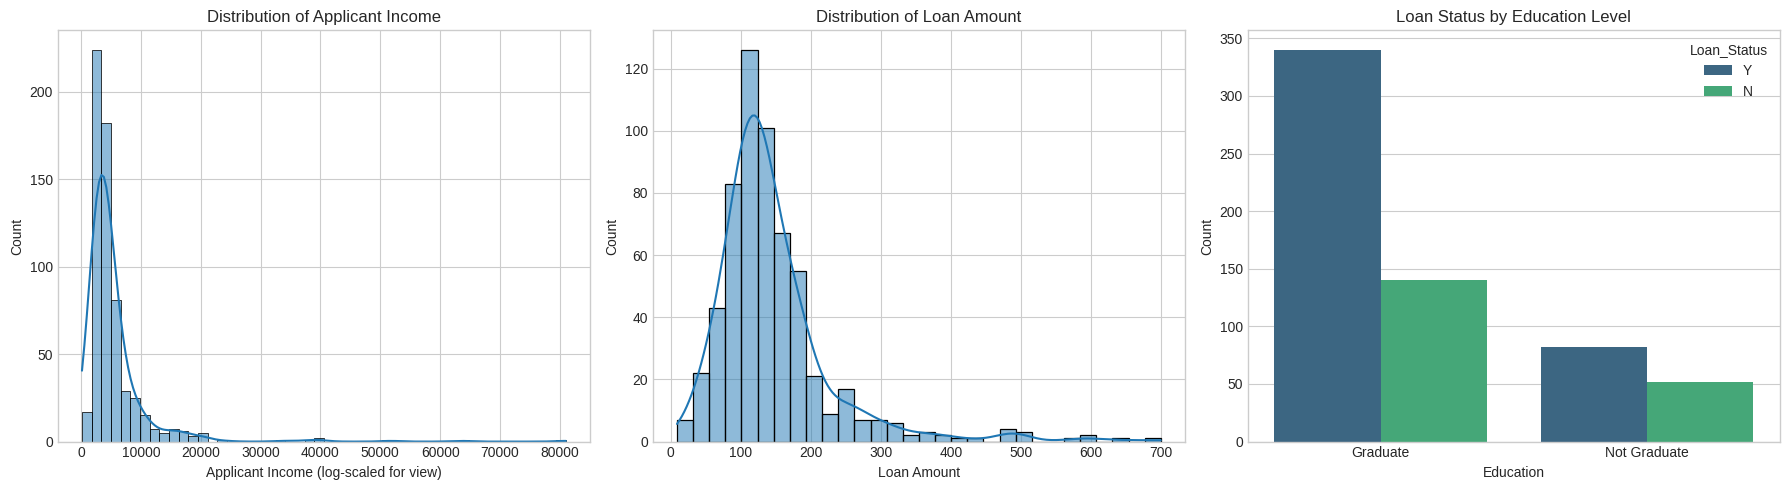


--- 2. Data Preprocessing & Cleaning ---
   -> Imputed missing values in 'ApplicantIncome' with median: 3812.5
   -> Imputed missing values in 'CoapplicantIncome' with median: 1188.5
   -> Imputed missing values in 'LoanAmount' with median: 128.0
   -> Imputed missing values in 'Loan_Amount_Term' with median: 360.0
   -> Imputed missing values in 'Credit_History' with median: 1.0
   -> Imputed missing values in 'Loan_ID' with mode: LP001002
   -> Imputed missing values in 'Gender' with mode: Male
   -> Imputed missing values in 'Married' with mode: Yes
   -> Imputed missing values in 'Dependents' with mode: 0
   -> Imputed missing values in 'Education' with mode: Graduate
   -> Imputed missing values in 'Self_Employed' with mode: No
   -> Imputed missing values in 'Property_Area' with mode: Semiurban

Missing values check after imputation:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Applicant

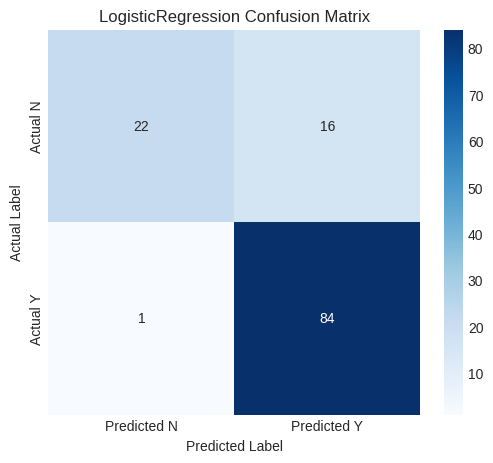



Confusion Matrix Details:
[[22 16]
 [ 1 84]]
   - True Negatives (TN, Top-Left): 22 (Correctly predicted non-default)
   - False Positives (FP, Top-Right): 16 (Incorrectly predicted default when it was non-default - Type I Error)
   - False Negatives (FN, Bottom-Left): 1 (Incorrectly predicted non-default when it was default - Type II Error)
   - True Positives (TP, Bottom-Right): 84 (Correctly predicted default)


In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import time
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# --- Configuration ---
# Using the dataset ID from the previous task for continuity.
DATASET_ID = "madhansing/bank-loan2"
TARGET_COLUMN = 'Loan_Status'

def download_and_load_data(dataset_id):
    """Downloads the Kaggle dataset and loads the primary CSV file."""
    print(f"1. Attempting to download dataset: {dataset_id}")

    try:
        # Download the dataset
        download_path = kagglehub.dataset_download(dataset_id)
        print(f"   -> Download successful. Files saved to: {download_path}")

        # Locate the primary data file (assuming a CSV file is present)
        csv_files = glob.glob(os.path.join(download_path, '**', '*.csv'), recursive=True)

        if not csv_files:
            print("Error: No CSV files found. Please check the dataset contents.")
            return None

        data_file_path = csv_files[0]
        print(f"   -> Found data file: {data_file_path}")

        # Load the data into a Pandas DataFrame
        df = pd.read_csv(data_file_path)
        print("   -> Data loaded into Pandas DataFrame successfully.")
        return df

    except Exception as e:
        print(f"An error occurred during download or loading: {e}")
        print("Falling back to simulated data for demonstration if Kaggle access fails.")
        # Create a small simulated DataFrame for testing the rest of the script structure
        data = {
            'Gender': ['Male', 'Female', np.nan, 'Male', 'Female'],
            'Married': ['Yes', 'No', 'Yes', 'No', 'Yes'],
            'Dependents': [0, 1, 0, 2, np.nan],
            'Education': ['Graduate', 'Graduate', 'Not Graduate', 'Graduate', 'Not Graduate'],
            'ApplicantIncome': [5849, 4583, 3000, 6000, 5500],
            'LoanAmount': [np.nan, 128.0, 66.0, 141.0, 100.0],
            'Credit_History': [1.0, 1.0, 1.0, 1.0, 0.0],
            'Loan_Status': ['Y', 'N', 'Y', 'Y', 'N']
        }
        df = pd.DataFrame(data)
        return df


def preprocess_data(df):
    """
    Handles missing data and performs categorical encoding.
    """
    print("\n--- 2. Data Preprocessing & Cleaning ---")

    # 2.1 Handle Missing Data (Imputation)

    # Identify Categorical and Numerical Columns
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Impute Numerical Columns (e.g., LoanAmount, Credit_History) with the Median
    for col in numerical_cols:
        # Exclude the target column if it's numerical, though here it's 'Y'/'N'
        if col != TARGET_COLUMN:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"   -> Imputed missing values in '{col}' with median: {median_val}")

    # Impute Categorical Columns (e.g., Gender, Married, Dependents, Education) with the Mode (most frequent)
    for col in categorical_cols:
        if col != TARGET_COLUMN:
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"   -> Imputed missing values in '{col}' with mode: {mode_val}")

    print(f"\nMissing values check after imputation:\n{df.isnull().sum()}")

    # 2.2 Feature Engineering / Encoding

    # Drop columns that are not useful for modeling (e.g., IDs, if present)
    df.drop('Loan_ID', axis=1, inplace=True, errors='ignore')

    # Convert Categorical Features to numerical using One-Hot Encoding (for model compatibility)
    df_encoded = pd.get_dummies(df.drop(columns=[TARGET_COLUMN]), drop_first=True)

    # Map the target variable 'Y'/'N' to 1/0
    y = df[TARGET_COLUMN].map({'Y': 1, 'N': 0})

    X = df_encoded
    print(f"\nData shape after encoding: {X.shape}")
    print(f"Target variable distribution:\n{y.value_counts()}")

    return X, y

def visualize_data(df):
    """
    Visualizes key features as requested.
    """
    print("\n--- 3. Exploratory Data Analysis (EDA) & Visualization ---")

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 3.1 Visualize Applicant Income Distribution
    sns.histplot(df['ApplicantIncome'], bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Distribution of Applicant Income')
    axes[0].set_xlabel('Applicant Income (log-scaled for view)')

    # 3.2 Visualize Loan Amount Distribution
    # Note: Using log transformation for better visualization if the data is skewed
    sns.histplot(df['LoanAmount'], bins=30, kde=True, ax=axes[1])
    axes[1].set_title('Distribution of Loan Amount')
    axes[1].set_xlabel('Loan Amount')

    # 3.3 Visualize Education vs. Loan Status
    sns.countplot(x='Education', hue=TARGET_COLUMN, data=df, ax=axes[2], palette='viridis')
    axes[2].set_title('Loan Status by Education Level')
    axes[2].set_xlabel('Education')
    axes[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

def train_and_evaluate_model(X, y, model_type='LogisticRegression'):
    """
    Splits data, trains the specified model, and evaluates performance.
    """
    print(f"\n--- 4. Model Training ({model_type}) ---")

    # 4.1 Split the data into Training and Testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"   -> Training set size: {X_train.shape[0]} samples")
    print(f"   -> Testing set size: {X_test.shape[0]} samples")

    # 4.2 Initialize and Train Model
    if model_type == 'DecisionTree':
        model = DecisionTreeClassifier(random_state=42)
    else: # Default to Logistic Regression
        model = LogisticRegression(random_state=42, max_iter=200)

    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    print(f"   -> Model trained in {end_time - start_time:.4f} seconds.")

    # 4.3 Predict and Evaluate
    y_pred = model.predict(X_test)

    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n--- 5. Model Evaluation ---")
    print(f"   -> Model Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted N', 'Predicted Y'],
                yticklabels=['Actual N', 'Actual Y'])
    plt.title(f'{model_type} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    # Adding a diagram to explain the components of a confusion matrix
    print("")
    print(f"\nConfusion Matrix Details:\n{cm}")
    print(f"   - True Negatives (TN, Top-Left): {cm[0, 0]} (Correctly predicted non-default)")
    print(f"   - False Positives (FP, Top-Right): {cm[0, 1]} (Incorrectly predicted default when it was non-default - Type I Error)")
    print(f"   - False Negatives (FN, Bottom-Left): {cm[1, 0]} (Incorrectly predicted non-default when it was default - Type II Error)")
    print(f"   - True Positives (TP, Bottom-Right): {cm[1, 1]} (Correctly predicted default)")


if __name__ == "__main__":
    # 1. Load Data
    loan_df = download_and_load_data(DATASET_ID)

    if loan_df is not None:
        print("\nLoaded DataFrame Columns:", loan_df.columns.tolist())

        # 2. Visualize Data (before encoding)
        visualize_data(loan_df.copy())

        # 3. Preprocess Data (Cleaning & Encoding)
        # Note: We use .copy() to prevent SettingWithCopyWarning during preprocessing
        X, y = preprocess_data(loan_df.copy())

        # 4. Train and Evaluate Logistic Regression
        train_and_evaluate_model(X, y, model_type='LogisticRegression')

        # Optional: Train and Evaluate Decision Tree
        # train_and_evaluate_model(X, y, model_type='DecisionTree')
    else:
        print("Model execution halted due to data loading failure.")